In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix

In [2]:
# pd.read_csv('ps2_public.csv')

In [3]:
df = pd.read_csv('ps2_public.csv')

In [4]:
df.isnull().sum() #To check for missing value

treatment            0
age                  0
blood_pressure       0
gender               0
blood_test           0
family_history    2607
TestA                0
TestB                0
GeneC                0
GeneD                0
GeneE                0
GeneF                0
dtype: int64

In [5]:
# check values for 'family_history'column
df['family_history'].value_counts()

False    4824
True       69
Name: family_history, dtype: int64

In [6]:
# EDA

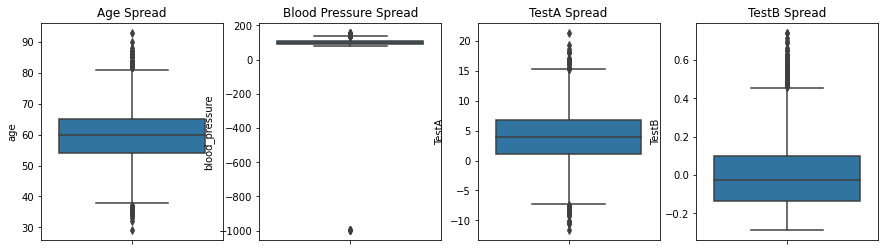

In [7]:
# inspect data for potential outliers
plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
plt.title('Age Spread')
sns.boxplot(y=df.age)

plt.subplot(1,4,2)
plt.title('Blood Pressure Spread')
sns.boxplot(y=df.blood_pressure)

plt.subplot(1,4,3)
plt.title('TestA Spread')
sns.boxplot(y=df.TestA)

plt.subplot(1,4,4)
plt.title('TestB Spread')
sns.boxplot(y=df.TestB)

plt.show()

In [8]:
df['treatment'].value_counts()

1    4144
0    3356
Name: treatment, dtype: int64

In [9]:
# EDA

In [10]:
# now we want to investgate TestB which is positively skewed with a lot of outliers > 0.4
df['TestB'].describe()

count    7500.000000
mean       -0.000590
std         0.171500
min        -0.288422
25%        -0.134452
50%        -0.027296
75%         0.101578
max         0.740719
Name: TestB, dtype: float64

For the entire dataset we have 4144 people(55%) treated and 3356(45%) not treated


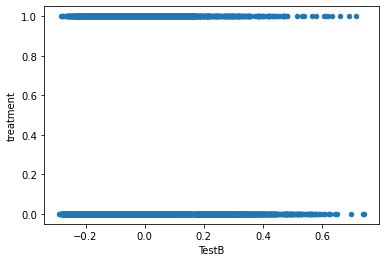

In [11]:
# df['treatment'].value_counts()
print('For the entire dataset we have 4144 people(55%) treated and 3356(45%) not treated')
ax1 = df.plot.scatter(x='TestB', y='treatment')
# but we can see that when TestB gets higher than 0.4, we have a lot more 0 than 1

In [12]:
# use the maximun threshold for TestB as a cutoff
TestB_Q1 = df['TestB'].quantile(0.25)
TestB_Q3 = df['TestB'].quantile(0.75)
TestB_IQR = TestB_Q3 - TestB_Q1
TestB_uplimit = TestB_Q3 + 1.5*TestB_IQR
# print(TestB_uplimit)

# calculate the percentage being treated above this maximum threshold
df2 = df[['treatment','TestB']]
df2 = df2.sort_values(by=['TestB'],ascending=False)
df2 = df2.loc[(df2['TestB'] >= TestB_uplimit)]
treated = df2['treatment'].sum()
total = len(df2.index)
Bpercent = treated/total
print('For TestB value over',round(TestB_uplimit,3),',the percentage of treated patients is only',round(Bpercent,3))

For TestB value over 0.456 ,the percentage of treated patients is only 0.2


In [13]:
# DATA CLEANING & PREPROCESSING

In [14]:
# remove outliers for blood pressure
# note that even though TestB is also skewed, we are not removing it yet
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lowlimit = Q1 - 1.5*IQR
    uplimit = Q3 + 1.5*IQR
    df = df.loc[(df[column] > lowlimit) & (df[column] < uplimit)]
    return df

df = remove_outliers(df, 'blood_pressure')
# An it leaves us with 7394 rows left

In [15]:
pd.options.mode.chained_assignment = None
# since 'True' is only 1.4%, we will impute the n/a with mode (False)
df['family_history'] = df['family_history'].fillna(False)

In [16]:
# encode categorical variables to interger 0&1
clean_up = {'gender': {'female':0,'non-female':1}, 'blood_test':{'negative':0,'positive':1},
            'family_history': {False:0, True:1}, 'GeneC':{'not active':0,'active':1}}
df = df.replace(clean_up)

In [17]:
# now lets look at the statistical significance of attribute A to F regarding treatment
df.corr()

,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
treatment,1.000000,-0.194459,0.111245,-0.457649,-0.028653,0.073524,-0.187443,-0.083160,0.007166,-0.007356,-0.044977,-0.022318
age,-0.194459,1.000000,0.001373,-0.005466,-0.014071,-0.031792,0.969723,-0.008042,-0.005168,0.004561,0.015189,-0.012345
blood_pressure,0.111245,0.001373,1.000000,0.002693,0.012265,0.020364,0.000593,0.000598,0.008845,0.007527,-0.000855,-0.000980
gender,-0.457649,-0.005466,0.002693,1.000000,-0.007949,0.013872,-0.007061,0.003270,-0.006763,-0.011640,-0.010008,-0.007980
blood_test,-0.028653,-0.014071,0.012265,-0.007949,1.000000,0.000657,-0.013846,0.030955,0.026035,-0.017016,0.008942,-0.005762
family_history,0.073524,-0.031792,0.020364,0.013872,0.000657,1.000000,-0.029889,-0.003225,0.019578,-0.005362,-0.008615,0.022469
TestA,-0.187443,0.969723,0.000593,-0.007061,-0.013846,-0.029889,1.000000,-0.005243,-0.003147,0.007472,0.016346,-0.013053
TestB,-0.083160,-0.008042,0.000598,0.003270,0.030955,-0.003225,-0.005243,1.000000,-0.010860,0.001947,-0.007427,0.003342
GeneC,0.007166,-0.005168,0.008845,-0.006763,0.026035,0.019578,-0.003147,-0.010860,1.000000,0.007685,-0.001169,0.008423
GeneD,-0.007356,0.004561,0.007527,-0.011640,-0.017016,-0.005362,0.007472,0.001947,0.007685,1.000000,0.006992,0.011064


In [18]:
# getting p-values to check statistical significance

corrf1 = stats.pearsonr(df.treatment,df.TestA)
print('Correlation and P-value for TestA:',corrf1)
corrf2 = stats.pearsonr(df.treatment,df.TestB)
print('Correlation and P-value for TestB:',corrf2)
corrf3 = stats.pearsonr(df.treatment,df.GeneC)
print('Correlation and P-value for GeneC:',corrf3)
corrf4 = stats.pearsonr(df.treatment,df.GeneD)
print('Correlation and P-value for GeneD:',corrf4)
corrf5 = stats.pearsonr(df.treatment,df.GeneE)
print('Correlation and P-value for GeneE:',corrf5)
corrf6 = stats.pearsonr(df.treatment,df.GeneF)
print('Correlation and P-value for GeneF:',corrf6)
print('\nWe can see that TestA, TestB, GeneE has significant p-value (<0.05)')

Correlation and P-value for TestA: (-0.1874431195498248, 1.9124231839474813e-59)
Correlation and P-value for TestB: (-0.08316009862585437, 7.950839141281101e-13)
Correlation and P-value for GeneC: (0.007166068964546393, 0.5378269853271901)
Correlation and P-value for GeneD: (-0.007355566967096191, 0.5271289032165436)
Correlation and P-value for GeneE: (-0.044976611486748114, 0.00010938602989472011)
Correlation and P-value for GeneF: (-0.02231777293433616, 0.0549864244367583)

We can see that TestA, TestB, GeneE has significant p-value (<0.05)


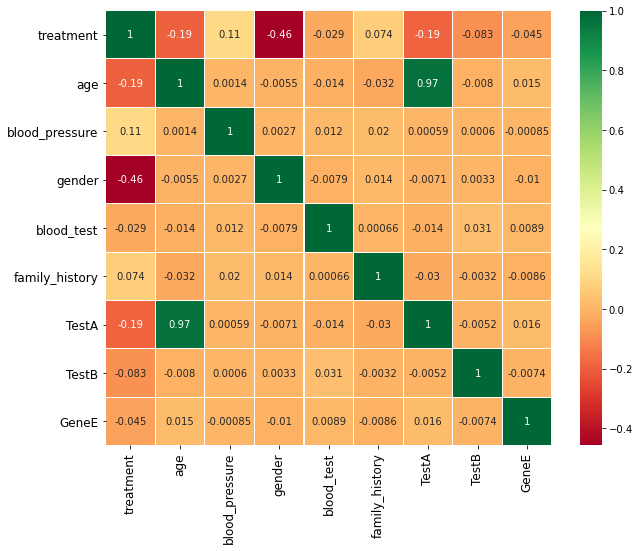

In [19]:
# now we will start selecting features to include in the model
# to better understand correlation among variables, we can plot a heatmap
fig=sns.heatmap(df[['treatment', 'age', 'blood_pressure', 'gender', 'blood_test','family_history',
                    'TestA', 'TestB', 'GeneE']].corr(), annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
# we noticed a high correlation between age&TestA, age&treatment, gender&treatment

In [20]:
Xvif = df[['age', 'blood_pressure', 'gender', 'blood_test','family_history',
           'TestA','TestB','GeneE','GeneF']] 
vifs = pd.DataFrame() 
vifs['vars'] = Xvif.columns 
  
# calculating VIF for each variable 
vifs['vif'] = [variance_inflation_factor(Xvif.values, i) 
                          for i in range(len(Xvif.columns))]   
print(vifs)
# Both age&blood pressure has high vif, but removing them might weaken the predictoin model

             vars        vif
0             age  87.382353
1  blood_pressure  62.426956
2          gender   1.612646
3      blood_test   1.094500
4  family_history   1.011567
5           TestA   5.232337
6           TestB   1.001116
7           GeneE   2.226505
8           GeneF   2.228182


In [30]:
# now we split the data into train/test sets
train_ratio = 0.80
test_ratio = 0.20

cols = ['age','blood_pressure', 'gender', 'blood_test','family_history',
        'TestA','TestB','GeneC','GeneD','GeneE','GeneF']
dataX = df[cols]
dataY = df['treatment']
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, train_size=train_ratio, test_size=test_ratio,random_state=1)

print(x_train.shape, x_test.shape)

(5915, 11) (1479, 11)


In [31]:
# After splitting the data, apply scaler to certain variables (on both train&test)
scaler = MinMaxScaler()
num_vars = ['age','blood_pressure','TestA','TestB']
x_train[num_vars] = scaler.fit_transform(x_train[num_vars])
x_test[num_vars] = scaler.fit_transform(x_test[num_vars])
x_train.head()

,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
6546,0.372881,0.629114,1,0,0,0.352785,0.300960,1,1,0,0
613,0.610169,0.397067,0,0,0,0.562991,0.218910,1,1,0,0
216,0.644068,0.657820,0,1,0,0.646093,0.510788,1,1,0,0
5874,0.576271,0.241607,1,0,0,0.533020,0.487568,1,1,1,0
5727,0.559322,0.666356,0,0,0,0.578902,0.440819,0,0,0,1


In [32]:
# start RFE feature selection

In [35]:
X = x_train[cols]
y = y_train
# Build a logreg and compute the feature importances
model = linear_model.LogisticRegression()
# create the RFE model and select 4/6/10 attributes
rfe = RFE(model, 6)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['age', 'blood_pressure', 'gender', 'family_history', 'TestA', 'TestB']


/Users/linyingxi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Optimal number of features: 10
Selected features: ['age', 'blood_pressure', 'gender', 'blood_test', 'family_history', 'TestA', 'TestB', 'GeneD', 'GeneE', 'GeneF']


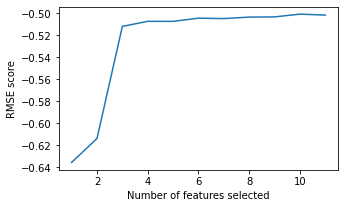

In [25]:
# Create the RFE object and compute a cross-validated score.
# The accuracy scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=linear_model.LogisticRegression(), cv=5, scoring='neg_root_mean_squared_error')
rfecv.fit(X, y)

print('Optimal number of features: %d' % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(5,3))
plt.xlabel("Number of features selected")
plt.ylabel("RMSE score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [26]:
# dropping GeneC as a feature
x_train = x_train.drop('GeneC', 1)
x_test = x_test.drop('GeneC', 1)
x_train.head()

,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneD,GeneE,GeneF
6546,0.372881,0.629114,1,0,0,0.352785,0.300960,1,0,0
613,0.610169,0.397067,0,0,0,0.562991,0.218910,1,0,0
216,0.644068,0.657820,0,1,0,0.646093,0.510788,1,0,0
5874,0.576271,0.241607,1,0,0,0.533020,0.487568,1,1,0
5727,0.559322,0.666356,0,0,0,0.578902,0.440819,0,0,1


In [29]:
# build and evaluate model
loreg = linear_model.LogisticRegression()
loreg.fit(x_train,y_train)
y_pred=loreg.predict(x_test)

accuracy = metrics.accuracy_score(y_test,y_pred)
ave_precision = metrics.average_precision_score(y_test,y_pred)
f1 = metrics.f1_score(y_test,y_pred)
auc = metrics.roc_auc_score(y_test,y_pred)
r2 = metrics.r2_score(y_test,y_pred)

print('Accuracy:',accuracy)
print('Average precision score:',ave_precision)
print('f1 score:',f1)
print('AUC score:',auc)
print('R-squared:',r2)
print('Coefficients:',loreg.coef_)

Accuracy: 0.7200811359026369
Average precision score: 0.6792901668149708
f1 score: 0.7642369020501139
AUC score: 0.7089722696418761
R-squared: -0.12880366051050984
Coefficients: [[-2.58871272  1.39774848 -2.29402451 -0.30867135  2.37672151 -1.31961762
  -1.43839292 -0.08526454 -0.2271194  -0.19201515]]


False Positive ratio = 0.4145616641901932
False Negative ratio = 0.1674937965260546


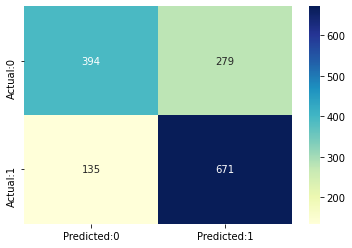

In [28]:
# now let's plot a confusion matrix to look at more measures
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (6,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap='YlGnBu')
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
print('False Positive ratio =',FP/float(TN+FP))
print('False Negative ratio =',FN/float(TP+FN))